---

# IT00CJ42: Search and Optimization Algorithms

**Restart the kernel and run all cells** before you turn this problem in, make sure everything runs as expected.

Make sure you fill in any place that says `YOUR CODE HERE`.

---

## Week 8: Multi-objective Genetic Algorithm

The task for this week is to implement a multi-objective genetic algorithm for the problem of test selection (See task week 2 and 5). You need to complete the task from week 7 before you can start with this one.

The goal is to design a test selection algorithm that given a set of tests T, selects a subset of T such that:

* minimizes the total execution time
* maximizes the total code coverage

First examine the Python code in the file ga-moo.py. It already implements the main loop of the genetic algorithm as well as a Python class to represent our test database and objective functions. This code is given as a reference. You can use as it is our change it if helps you.

Your tasks are:

2.a Implement the fitness function and selection operator so they take into account the concepts of Pareto dominance and Pareto front of the population (3p)

2.b Solve the problems in the files problem1.txt, problem2.txt and problem3.txt and report the obtained Pareto front for each problem (1p)

### Imports

In [14]:
import copy
import random

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import rand, randint, uniform

random.seed(1)

### Solutions check
We use the function **check** to implement tests for your solution

In [15]:
def check(expression, message=""):
    if not expression:
        raise AssertionError(message)
    return "Passed"

### Test database
This is already implemented

In [16]:
class TestDatabase:
    # This class represents our test database
    # It is already implemented
    def __init__(self):
        self.coverage = []
        self.time = []

    def get_time(self, i):
        return self.time[i]

    def get_coverage(self, i):
        return self.coverage[i]

    def get_number_of_tests(self):
        return len(self.time)

    def init_random(self, n_tests, max_time, max_code, p=0.05):
        # initialize a test database randomly
        self.coverage = []
        self.time = []
        for i in range(n_tests):
            t_time = randint(1, max_time)
            t_coverage = []
            for i in range(1, max_code + 1):
                if rand() < p:
                    t_coverage.append(i)
            self.time.append(t_time)
            self.coverage.append(t_coverage)

    def load_from_file(self, fn):
        # load test database from file with name fn
        # file format:
        #  line i represents test i as comma separated value
        #   the first value is the time to execute the test
        #   the other values are the lines covered by the test
        #  Example
        #   5, 1, 5, 7 -> A test that covers lines 1,5,7 and takes 5 seconds to run
        self.coverage = []
        self.time = []
        with open(fn, "rt") as fd:
            for line in fd.readlines():
                words = line.split(",")
                self.time.append(float(words[0]))
                self.coverage.append(list(map(lambda x: int(x), words[1:])))

    def write_to_file(self, fn):
        # write the test database to a file with name fn
        with open(fn, "wt") as fd:
            for time, coverage in zip(self.time, self.coverage):
                fd.write(str(time))
                for i in coverage:
                    fd.write(", " + str(i))
                fd.write("\n")

### Objective Function
This is already implemented

Each solution is a set of tests and has two objectives total execution time, to be minimized total program coverage, to be maximized

In [17]:
def objectives(x, db, cache={}):
    # returns the objectives of a solution
    # this function is ready
    # Note that the dictionary used as default value for cache is initialized once
    # when the module is created!
    coverage = set()
    total_time = 0
    if db not in cache:
        # first use with TestDatabase object
        cache[db] = {}
    x = tuple(x)
    if x in cache[db].keys():
        # cache hit
        return cache[db][x]

    for i in range(len(x)):
        if x[i] == 1:
            total_time = total_time + db.get_time(i)
            coverage.update(db.get_coverage(i))
    result = (total_time, len(coverage))
    cache[db][x] = result
    return result

### Genetic algorithm
This is already implemented  (can be changed)

In [18]:
def genetic_algorithm(db, fitness, n_bits, n_iter, n_pop, r_cross, r_mut):
    # initial population of random bitstring
    population = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
    # enumerate generations
    for gen in range(n_iter):
        # evaluate all candidates in the population

        # adding the pareto front rank for each candidate
        scores = [fitness(c, db) for c in population]

        # select parents
        selected = [selection(population, scores) for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i + 1]
            # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                c = mutation(c, r_mut)
                # store for next generation
                children.append(c)
        # replace population
        population = children
        # plot progress
        if gen == n_iter:
            plot_population(gen, population, db)
    # plot final population
    plot_population(n_iter, population, db)
    return pareto_front(population, db), population

### Task 1: Multi objective fitness function

In [19]:
def fitness(solution, db):
    execution_time = 0
    code_coverage = 0
    for i in range(len(solution)):
        if solution[i] == 1:
            execution_time += db.get_time(i)
            code_coverage += len(db.get_coverage(i))
    return execution_time, -code_coverage


### Task 2: Selection method with multi objective fitness function and pareto front

In [20]:
def selection(population, scores, k=3):
    # Tournament size can be adjusted. 
    tournament_size = k
    # Randomly select individuals for the tournament
    tournament_indices = [random.randrange(len(population)) for _ in range(tournament_size)]
    # Select the index of the individual with the highest fitness in the tournament
    best_index = tournament_indices[0]
    for index in tournament_indices:
        if scores[index] > scores[best_index]:
            best_index = index
    # Return the winning individual from the population
    return population[best_index]


### Crossover method

In [21]:
def crossover(p1, p2, r_cross):
    if random.random() < r_cross:
        point = randint(1, len(p1) - 2)
        return p1[:point] + p2[point:], p2[:point] + p1[point:]
    return p1, p2


### Mutation operator

In [22]:
def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        if random.random() < r_mut:
            bitstring[i] = 1 - bitstring[i]
    return bitstring


### Pareto domination and pareto front functions

In [23]:
def pareto_domination(a, b, db):
    # Returns True if solution a dominates solution b ?
    # First objective (time) should be minimized
    # The second objective (coverage) should be maximized
    r = False
    if objectives(a, db)[0] < objectives(b, db)[0]:
        r = True
    elif objectives(b, db)[0] < objectives(a, db)[0]:
        return False
    if objectives(a, db)[1] > objectives(b, db)[1]:
        r = True
    elif objectives(b, db)[1] > objectives(a, db)[1]:
        return False
    return r

In [24]:
def pareto_front(population, db):
    # Returns the pareto front of the population
    r = set()
    for p in population:
        r.add(tuple(p))
        for i in copy.copy(r):
            if i == tuple(p):
                continue
            if pareto_domination(i, p, db):
                r.remove(tuple(p))
                break
            elif pareto_domination(p, i, db):
                r.remove(tuple(i))
    return r

#### Show a plot with the population and the pareto front

In [25]:
def plot_population(generation, population, db):
    front = pareto_front(population, db)
    plt.scatter(
        list(map(lambda i: objectives(i, db)[0], population)),
        list(map(lambda i: objectives(i, db)[1], population)),
        color="blue",
    )
    plt.scatter(
        list(map(lambda i: objectives(i, db)[0], front)),
        list(map(lambda i: objectives(i, db)[1], front)),
        color="red",
        s=50,
    )
    plt.plot(
        sorted(list(map(lambda i: objectives(i, db)[0], front))),
        sorted(list(map(lambda i: objectives(i, db)[1], front))),
        color="red",
        lw=2.5,
        label="Pareto front",
    )
    plt.title("Generation " + str(generation))
    plt.xlabel("Time")
    plt.ylabel("Code Coverage")
    plt.legend()
    plt.show()

### Initialize the problems

In [26]:
p1 = TestDatabase()
p1.load_from_file("../res/data/problem1.txt")

p2 = TestDatabase()
p2.load_from_file("../res/data/problem2.txt")

p3 = TestDatabase()
p3.load_from_file("../res/data/problem3.txt")

max_time = 1000

#### Problem 1
##### Initialize the parameters and solve the problem with the genetic algorithm

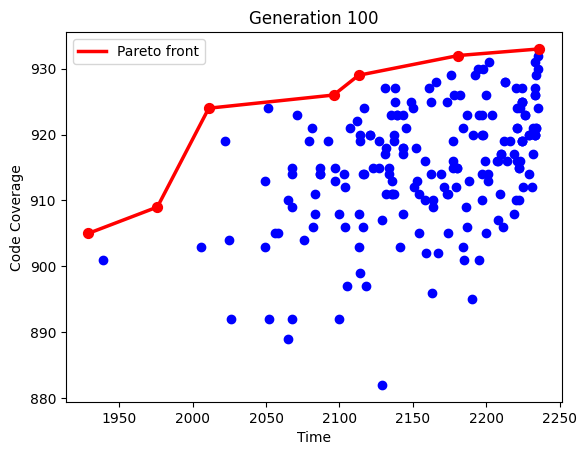

In [27]:
n_iter = 100
# bits: one bit per each test that may be executed
n_bits = p1.get_number_of_tests()
# define the population size, you can change this
n_pop = 200
# crossover rate, you can change this
r_cross = 0.9
# mutation rate, you can change this
r_mut = 1.0 / float(n_bits)

front, population = genetic_algorithm(
    p1, fitness, n_bits, n_iter, n_pop, r_cross, r_mut
)

Discuss the pareto front; is it optimal? could it be improved? Try different parameters and see if it changes.

A Pareto front is "optimal" in a multi-objective sense if it accurately represents the trade-off frontier where no improvements can be made in one objective without sacrificing another. Whether the obtained Pareto front is optimal depends on the diversity and quality of solutions it contains.

Image 1 (n_pop = 200, r_cross = 0.9): This setup shows a Pareto front that stretches across a broad range of the objective space, suggesting that a larger population size has allowed the GA to explore more diverse solutions. The higher crossover rate has likely contributed to the convergence of solutions towards a Pareto optimal front, as indicated by the dense clustering of blue points near the red line.


#### Problem 1
##### Initialize the parameters and solve the problem with the genetic algorithm

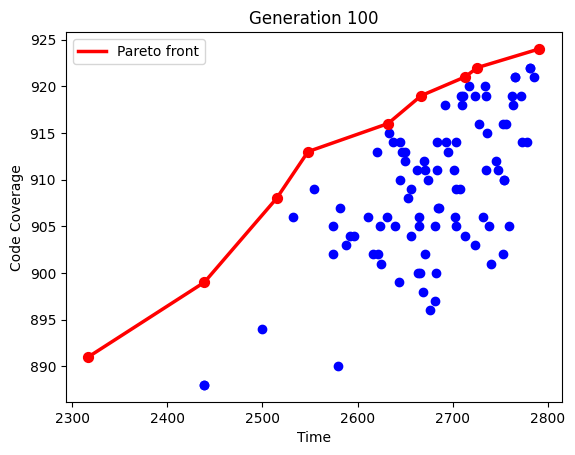

In [28]:
n_iter = 100
# bits: one bit per each test that may be executed
n_bits = p2.get_number_of_tests()
# define the population size, you can change this
n_pop = 100
# crossover rate, you can change this
r_cross = 0.9
# mutation rate, you can change this
r_mut = 1.0 / float(n_bits)

front, population = genetic_algorithm(
    p2, fitness, n_bits, n_iter, n_pop, r_cross, r_mut
)

Discuss the pareto front; is it optimal? could it be improved? Try different parameters and see if it changes.

Image 2 (n_pop = 100, r_cross = 0.9): With a smaller population, the diversity of solutions is less compared to the first image. The Pareto front is smoother, which suggests the population has converged well, but possibly at the expense of exploring the entire objective space. The results may indicate that some potentially optimal solutions could be missed due to the smaller population size.

#### Problem 1
##### Initialize the parameters and solve the problem with the genetic algorithm

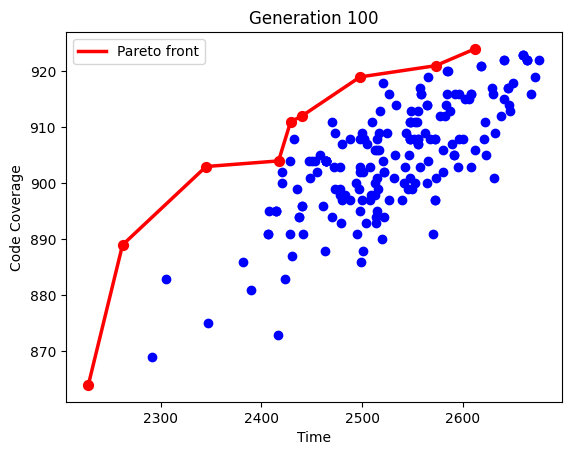

In [29]:
n_iter = 100
# bits: one bit per each test that may be executed
n_bits = p3.get_number_of_tests()
# define the population size, you can change this
n_pop = 200
# crossover rate, you can change this
r_cross = 0.7
# mutation rate, you can change this
r_mut = 1.0 / float(n_bits)

front, population = genetic_algorithm(
    p3, fitness, n_bits, n_iter, n_pop, r_cross, r_mut
)

Discuss the pareto front; is it optimal? could it be improved? Try different parameters and see if it changes.

Image 3 (n_pop = 200, r_cross = 0.7): The lower crossover rate combined with a larger population size leads to a Pareto front that is spread out, indicating a more extensive exploration of the solution space. The spread of blue points suggests less convergence, but the diversity is higher, which could be beneficial for finding a wide range of trade-off solutions.